### 90803 Final Project
# Classification of cities into Growth Categories

**Team 14**

Chi-Shiun Tsai & Colton Lapp


## Notebook Overview:

### Summary

This notebook tries to classify cities as "growing", "shrinking", or "netural" using ~40 input features. We achieve moderate success with accuracy rates around 60%. 

Here are the various steps we went through to accomplish this:


**Defining our Target Variable** 

We started with population data from 2019 and 2020 for every city. We divided these by each other to create percentage changes in population.

In order to do classification, we needed to turn this percent change into a categorical variable. Our first attempt simply created a binary split of "growing"/"Shrinking" depending on if the percent was positive or negative. We then refined this idea by including the 3rd category of "neutral" for cities which weren't growing. 

Defining "Neutral" was a challenge. Should only cities with the exact same population be considered "netural?" This obviously seemed rediculous. When we did EDA and looked at the scatterplot of growth rates and population, however, we saw that there was extreme heteroskedasticity among growth rates. Smaller cities unsurpsingly had much bigger growth rates than bigger cities. Our final conclusion was to classify cities into three size categories: small, medium and large, and then use different percent cutoffs for each one. We did this after looking at the 33rd and 66th percentiles of growth rates for different population bins. Our cutoffs make our class instances balanced and are also symmetrical around 0. 


**Feature Engineering**

Our baseline models weren't performing well. After doing some EDA, we realized that our variables are highly skewed. To address this, we took logs of our most skewed variables. After taking logs, the ranges for our variables were still very uneven so we also used the Robust Scalar to transform our dataset. 

**Seperate models for different city sizes**

Our models still weren't performing amazingly. Because small, medium and big cities are so different from each other, we wondered if we might be more succesful is we had a seperate model for each city size category. To test this, we split up our logged and scaled dataset into 3 subsets - small, medium and large cities and then estimated a seperate model for each dataset. This ultimately proved to only be mildly helpful. Sometimes the results were better, but sometimes they were worse, and our outcomes were usually poorly balanced across classes. 

**Tuning**

We tuned every model for every dataset using GridSearchCV. For some models it was more helpful than others.

**Validation**

We looked at a wide variety of metrics for every model. We graph the test accuracy, the CV weighted F1 score, as well as the F1 score of each individual class. We also made a table of the Test Weighted F1 scores and the Test accuracy for each model. The validation results showed that the Random Forest is the best model slightly but there are other similarly good models, such as SVM and Logistic regression, and each model had unique strenths and weaknesses. 

**Quality of Predictions**
When our class to predict was binary, our accuracy was a little over 50% without and engineering. This is pretty bad, considering a randomly guessing person could do similarly good on a balanced dataset. The accuracy dropped when we started doing multiclass prediction, but this is expected because there are now 3 categories instead of 2. After tuning and model selection, we were able to get scores around 60% which is not amazing but not terrible. 

**Models Used**

We used 4 models we learned from class (Logistic Regression, Random Forest, Naive Bayes, K Nearest Neighbors) as well as 1 new one: Support Vector Machines. 
We used SVM because some reference papers we read about predicting population change in machine learning said they had good success with support vector machines. We also read that SVM is good for datasets with complicated non-linear relationships, and we believe the relationships between city variables are likely non linear. We got pretty good results with the SVM, so this was encouraging.

*A note about structure of notebook*

We wanted to see how our models improved after tuning and also after our dataset transformations. To do this, we wrapped our model evaluation, tuning, and graphing in functions. We then were able to do all of these work in much less code and store the results for every combination of dataset and model. This structure allows us to see the impact of all of our steps.

### Conclusion and Future work
*See bottom of notebook*



### Import Modules

In [56]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
import warnings
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, make_scorer

%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Set Seed

In [57]:
seed = 0

### Read in Data

In [58]:
#Set Base Dir
base_dir = os.getcwd().split('/')
base_dir = '/'.join(base_dir[0:-1])
base_dir
df = pd.read_csv(base_dir + '/Team14_CL_CT_MG/data/data_all.csv', low_memory=False)
df.head()

,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,state,GEOID,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,36,3651000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,6,644000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
2,"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,17,1714000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542
3,"Houston city, Texas",2313238,53600.0,186800.0,1086.0,499608.0,42.481318,51.539271,44.471948,13.576078,1.126473,8.046470,17.088946,15.180669,10.985813,3.587785,2.314159,47.686144,1.748501,2.939646,36.207040,4.086998,3.904484,5.408134,0.727076,0.958916,1.097639,2.983826,2.628869,10.073672,5.207333,5.392571,6.563527,5.208932,0.410939,4.663031,2.628869,48,4835000,2310432,0.121449,1658093679,81248080,4991.616106,57.677759
4,"Phoenix city, Arizona",1658422,60914.0,250800.0,1100.0,258077.0,37.805637,68.233176,42.647046,11.954557,0.754512,11.002447,16.492967,14.118542,10.974408,3.490125,2.569792,48.881527,1.325778,4.060667,35.624769,3.587989,4.214126,6.030914,0.925096,1.144582,1.225804,4.415402,5.078864,6.408743,3.939890,4.255793,4.791905,3.291020,0.706636,2.782283,1.114433,4,455000,1633017,1.555709,1340766401,3236736,7307.164034,116.139965


## Set Up Data

### Adjust Row Names
Set city name as the row for reference

In [59]:
#Set row equal to name
df.set_index('Name', inplace=True, drop=True)

#Drop GEOID and STATE column
df = df.drop( ['GEOID', 'state'], axis=1)
df.head(1)

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.55683,6.763679,0.208245,3.913145,0.719466,8419316,-0.472295,777982727,434642000,5913.616647,220.640533


# Final Data Cleaning

#### Deal with columns that have missing values from the Census data
missing values are encoded as -66666666

In [60]:
starting_rows = df.shape[0]

#Forgot to normalize renter HH by population 
df['Renter Household'] = df['Renter Household']/df['Population 2020']

#Replace the missing value code from census data
df = df.replace(-666666666, np.nan)
missing = pd.DataFrame( df.isnull().sum(), columns = ['Num Missing'] )
print("Missing value counts")
missing[missing['Num Missing']>0]

Missing value counts


,Num Missing
Median Household Income,557
Median Home Value,623
Median Gross Rent,2453


#### Investigate which rows are missing...

In [61]:
df_missing = df[df.isna().any(axis=1)]
print("Population Stats for Rows with Missing Values")
print( df_missing[['Population 2020']].describe() )

print("\n\nPopulation Stats for Dataset")
print( df[['Population 2020']].describe() )

Population Stats for Rows with Missing Values
       Population 2020
count      2830.000000
mean        348.626148
std         854.599514
min           1.000000
25%          67.000000
50%         132.000000
75%         266.000000
max       11432.000000


Population Stats for Dataset
       Population 2020
count     1.949500e+04
mean      1.060153e+04
std       8.389515e+04
min       1.000000e+00
25%       3.880000e+02
50%       1.211000e+03
75%       4.813500e+03
max       8.379552e+06


## Analysis: Rows with missing values are dispraportionately tiny cities, so it's okay to drop them
Tiny cities are overrepresented in our dataset anyways and are less interesting

In [62]:
#Drop rows with NaN
df = df.dropna()

# Drop rows with infinite growth rates
# Find the indices of positive or negative infinity
inf_indices = np.isinf(df['Pop Chng %'])
# Drop rows
df = df[~inf_indices]

#Combine 2 columsn that should have been combined earlier
df['Population Age 15 or Older Never Married'] = df['Population Age 15 or Older Never Married'] + df['Population Age 15 or Older Never Married 2']
df.drop(['Population Age 15 or Older Never Married 2'], axis=1, inplace=True)

print("Went from {} rows to {} rows after cleaning".format(starting_rows, df.shape[0]))

Went from 19495 rows to 16665 rows after cleaning


## Check Data Types for df

In [63]:
df.dtypes

Population 2020                                                int64
Median Household Income                                      float64
Median Home Value                                            float64
Median Gross Rent                                            float64
Renter Household                                             float64
Total Housing Units                                          float64
Race: White Alone                                            float64
Hispanic or Latino                                           float64
Population Age 25 or Older: Bachelor`s Degree                float64
Population Age 25 or Older: Doctorate Degree                 float64
Pop 5-17 Speak only English at Home                          float64
Population Age 15 or Older Never Married                     float64
Population Age 65 or more                                    float64
Pop 65 or more Living in Nonfamily Households                float64
Females 20-64 w Own Children 0-17 

### All are correct data types

# Exploratory Data Analysis of Target Variable: Growth Rates

### Deciding how to classify growth rates
1. Small cities have much larger percentage changes in population due to base rate effect. Should we consider them differently?
2. Should we do a binary classification of growth/no growth or should we consider cities with growth rates close to 0 as "neutral"? Should we vary these cutoffs for city size considering that small growth rates for a big city are more significant than medium growth rates for a tiny city?

#### Investigate distribution of Population Size and various cutoffs for cities


In [64]:
#Get observation counts by bin size
total = df.dropna().shape[0]
num_100K = (df['Population 2020'] > 100000).sum()
num_50K = (df['Population 2020'] > 50000).sum()
num_25K = (df['Population 2020'] > 25000).sum()
num_10K = (df['Population 2020'] > 10000).sum()
num_5K = (df['Population 2020'] > 5000).sum()
num_1K = (df['Population 2020'] > 1000).sum()

print("\nHow many cities fall into different population levels?:\n", '-'*50, sep="")
print("Number of cities w/ >100K Pop:  ", num_100K, "   ... ",  round(100*num_100K/total, 3), "%", sep="" )
print("Number of cities w/ >50K Pop:   ", num_50K, "   ... ",  round(100*num_50K/total, 3), "%", sep="" )
print("Number of cities w/ >20K Pop:   ", num_25K, "  ... ",  round(100*num_25K/total, 3), "%", sep="" )
print("Number of cities w/ >10K Pop:   ", num_10K, "  ... ",  round(100*num_10K/total, 3), "%", sep="" )
print("Number of cities w/ >5K Pop:    ", num_5K, "  ... ",  round(100*num_5K/total, 3), "%", sep="" )
print("Number of cities w/ >1K Pop:    ", num_1K, " ... ",  round(100*num_1K/total, 3), "%", sep="" )
print('-'*50, "\n\n")


How many cities fall into different population levels?:
--------------------------------------------------
Number of cities w/ >100K Pop:  308   ... 1.848%
Number of cities w/ >50K Pop:   775   ... 4.65%
Number of cities w/ >20K Pop:   1516  ... 9.097%
Number of cities w/ >10K Pop:   3092  ... 18.554%
Number of cities w/ >5K Pop:    4745  ... 28.473%
Number of cities w/ >1K Pop:    10427 ... 62.568%
-------------------------------------------------- 




### Results:
Almost half of our cities have less than 1,000 people. Very few cities have more than 100K people. We may want to consider creating seperate models for different population sizes

### Plot kernal density of population with potential cutoff points

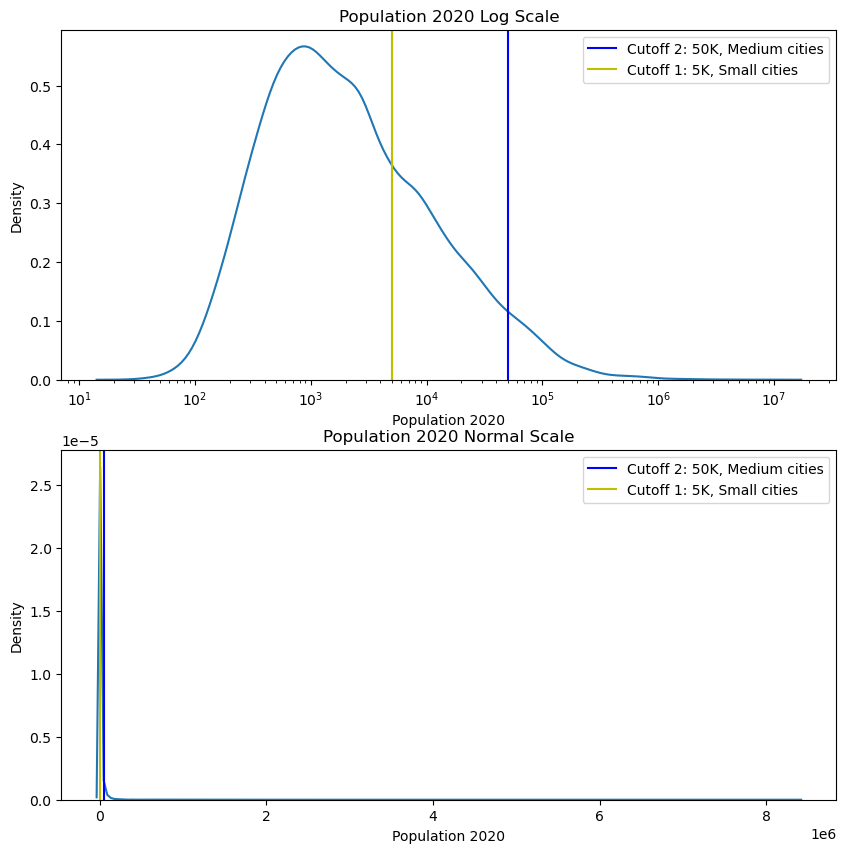

In [65]:
# create a figure with two subplots
fig, axs = plt.subplots(nrows=2, figsize = (10,10))

# plot the first kernel density plot in the first subplot
sns.kdeplot( df['Population 2020'], log_scale=True, ax=axs[0])
axs[0].set_title('Population 2020 Log Scale')

# plot the second kernel density plot in the second subplot
sns.kdeplot( df['Population 2020'], ax=axs[1])
axs[1].set_title('Population 2020 Normal Scale')

axs[0].axvline(x=50000, color='b', label='Cutoff 2: 50K, Medium cities')
axs[0].axvline(x=5000, color='y',  label='Cutoff 1: 5K, Small cities')
axs[0].legend()

axs[1].axvline(x=50000, color='b', label='Cutoff 2: 50K, Medium cities')
axs[1].axvline(x=5000, color='y',  label='Cutoff 1: 5K, Small cities')
axs[1].legend()

## Analysis: Our population size is incredibly skewed. 

### What do population growth rate changes look like for cities with different population sizes?

Text(0.5, 1.0, 'Population vs Pop Change Scatterplot')

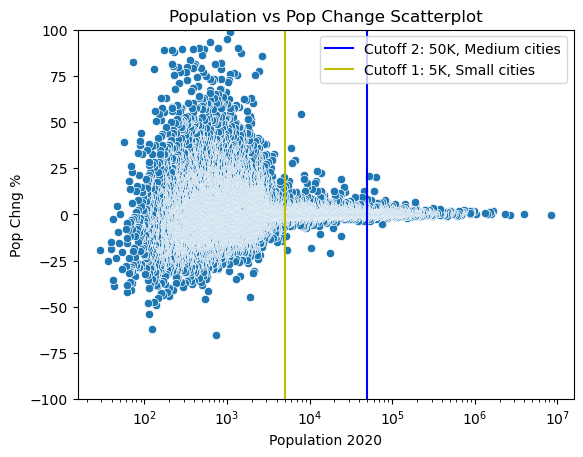

In [66]:
# create a scatterplot of population on the x-axis and change on the y-axis
p = sns.scatterplot(data=df, x='Population 2020', y='Pop Chng %')
p.set(ylim=(-100, 100))
plt.xscale('log')
plt.axvline(x=50000, color='b', label='Cutoff 2: 50K, Medium cities')
plt.axvline(x=5000, color='y',  label='Cutoff 1: 5K, Small cities')
plt.legend()

# set the plot title
plt.title('Population vs Pop Change Scatterplot')

### Looking at just cities with more than 5K people

Text(0.5, 1.0, 'Population vs Pop Change - Bigger cities only')

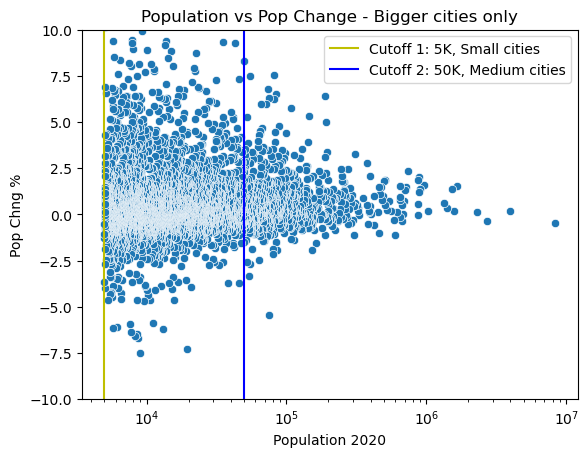

In [67]:
df_5K_more = df[df['Population 2020']>5000]

p = sns.scatterplot(data=df_5K_more, x='Population 2020', y='Pop Chng %')
p.set(ylim=(-10, 10))
plt.xscale('log')
plt.axvline(x=5000, color='y',  label='Cutoff 1: 5K, Small cities')
plt.axvline(x=50000, color='b', label='Cutoff 2: 50K, Medium cities')
plt.legend()

# set the plot title
plt.title('Population vs Pop Change - Bigger cities only')

# Set Cutoff Points for small/medium/big cities
This will be used to segment our dataset later

In [68]:
#Set cutoff points
small_cut = 5000
med_cut = 50000

## How to determine categories for "Shrinking", "Neutral" and "Growing" [depending on city size]
 
**Calculating 33rd and 66th percentile of population changes**
We will look at the data with certain population sizes and see the 33rd and 66th percentile for growth rates. This can help us determine what values we should use determining whether or not a city is shrinking/neutral/or growing

In [69]:
cutoffs = [0, 100, 1000, 5000, 10000,50000, 100000, 1000000, 10000000]

df.replace([np.inf, -np.inf], np.nan, inplace=True)

def disp_num(num):
    if num<999:
        return str(num)
    else:
        return str( round(num/1000, 2) ) + "K"

for i in range(0, len(cutoffs)-1):
    low, high = [cutoffs[i], cutoffs[i+1]]
    df_temp = df[df['Population 2020']>low]
    df_temp = df_temp[df_temp['Population 2020']<high]
    
    mi = round( np.nanmin( df_temp['Pop Chng %']) )
    pct_33 = round(np.percentile(df_temp['Pop Chng %'].dropna(), 33), 0)
    pct_66 = round(np.percentile(df_temp['Pop Chng %'].dropna(), 66), 0)
    ma = round( np.nanmax( df_temp['Pop Chng %']) )

    
    print("\nPercentiles of Pop % Chng for populations of:", disp_num(low),"-", disp_num(high), "\n", "-"*50)
    print("{}: {}".format('Count of cities', disp_num(df_temp.shape[0]) ) )
    print("{}: {} ~ {}".format("Shrinking", mi, pct_33))
    print("{}: {} ~ {}".format("Neutral", pct_33, pct_66))
    print("{}: {} ~ {}".format("Growing", pct_66, ma))


Percentiles of Pop % Chng for populations of: 0 - 100 
 --------------------------------------------------
Count of cities: 109
Shrinking: -42 ~ -19.0
Neutral: -19.0 ~ -3.0
Growing: -3.0 ~ 162

Percentiles of Pop % Chng for populations of: 100 - 1.0K 
 --------------------------------------------------
Count of cities: 6.12K
Shrinking: -65 ~ -6.0
Neutral: -6.0 ~ 6.0
Growing: 6.0 ~ 246

Percentiles of Pop % Chng for populations of: 1.0K - 5.0K 
 --------------------------------------------------
Count of cities: 5.68K
Shrinking: -45 ~ -1.0
Neutral: -1.0 ~ 2.0
Growing: 2.0 ~ 225

Percentiles of Pop % Chng for populations of: 5.0K - 10.0K 
 --------------------------------------------------
Count of cities: 1.65K
Shrinking: -19 ~ -0.0
Neutral: -0.0 ~ 1.0
Growing: 1.0 ~ 450

Percentiles of Pop % Chng for populations of: 10.0K - 50.0K 
 --------------------------------------------------
Count of cities: 2.32K
Shrinking: -21 ~ -0.0
Neutral: -0.0 ~ 1.0
Growing: 1.0 ~ 204

Percentiles of Pop 

# Data Transformations: Logging Skewed Features


# 1: Graph variables before logging
How many of our variables have a heavy skew to them?

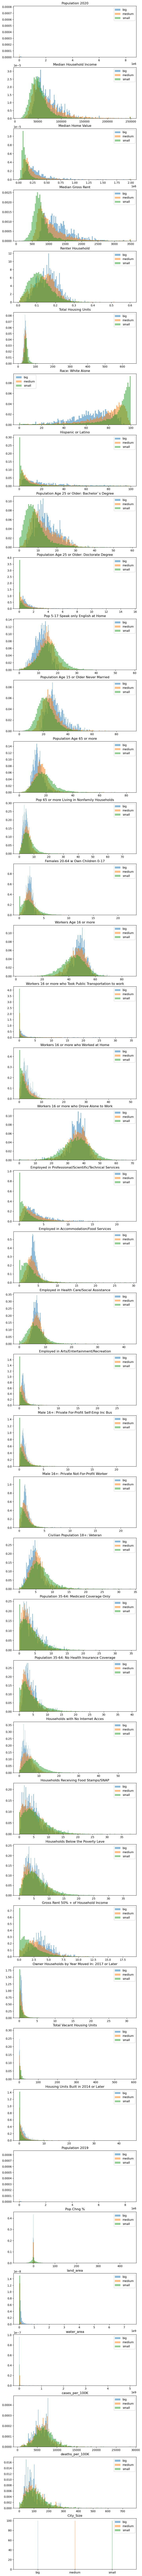

In [15]:
#Create variable to classify city as small/medium/large
def class_city(row):
    if row['Population 2020'] <small_cut:
        return "small"
    elif row['Population 2020'] <med_cut:
        return "medium"
    else:
        return "big"
    
# create new 'size' column using the apply function
df['City_Size'] = df.apply(lambda row: class_city(row), axis=1)  
df['City_Size'] = df['City_Size'].astype('category')

# Group the data by the "group" column
groups = df.groupby('City_Size')

# Loop through each group and plot a histogram with a different color
n_vars = len(df.columns)
#n_vars=2
col_names = df.columns.values

#Plot in a loop
fig, axs = plt.subplots(nrows=n_vars, ncols=1, figsize=(8, 4*n_vars))
for i in range(0, n_vars):
    for name, group in groups:
        axs[i].hist(group[col_names[i]], alpha=0.5, label=name, bins=100, density=True)
    axs[i].legend()
    axs[i].set_title(col_names[i])

# Create Datset of some variables log transformed
We will only transform variables with the heaviest skew

In [16]:
cols_original = df.columns.values
cols_new = list(cols_original)
vars_not_to_log  = ['Renter Household', 'Race: White Alone', "Hispanic or Latino",
                    'Population Age 25 or Older: Bachelor`s Degree','Pop 5-17 Speak only English at Home',
                    'Population Age 15 or Older Never Married', 'Pop Chng %',
                    'Females 20-64 w Own Children 0-17', 'Workers Age 16 or more', 'Workers 16 or more who Drove Alone to Work', 'City_Size']


df_logged = df.copy()

for col in df_logged.columns:
    if col not in vars_not_to_log:
        log_name = "log " + col
        df_logged[log_name] =  np.log(df_logged[col] + .1)
        df_logged = df_logged.drop(col, axis=1)
        
        ii = cols_new.index(col)
        cols_new =cols_new[:ii]+ ["log " + col]+ cols_new[ii+1:]

df_logged = df_logged[cols_new]

# 2. Graph dataset after logging most variables

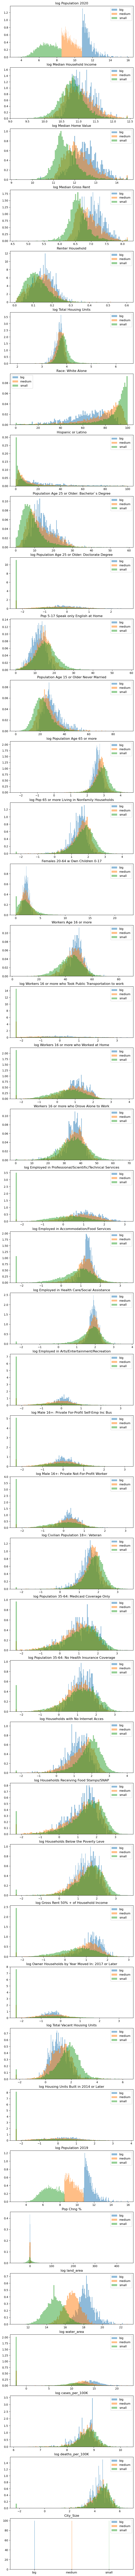

In [17]:
# Group the data by the "group" column
groups = df_logged.groupby('City_Size')

# Loop through each group and plot a histogram with a different color
n_vars = len(df_logged.columns.values)
#n_vars=2
col_names = df_logged.columns.values

#Plot in a loop
fig, axs = plt.subplots(nrows=n_vars, ncols=1, figsize=(8, 4*n_vars))
for i in range(0, n_vars):
    for name, group in groups:
        axs[i].hist(group[col_names[i]], alpha=0.5, label=name, bins=100, density=True)
    axs[i].legend()
    axs[i].set_title(col_names[i])

## Create 2 Target Variables Depending on Growth Rates / City Size
Small cities will have wide growth rates for "netural" while big cities will have narrow ones. I.e. if NY City grows 0.5%, that is "growing", but the same is not true for a town of 1000 people with the same growth rate

In [18]:
# define a function to apply to the 'population' column
def growth_function_binary(row):
    if row['Pop Chng %'] > 0:
        return 1
    else:
        return -1

#Different growth rates for cities with more than 5K people and cities with more than 50K people
def growth_function_3classes_sized(row):
    if row['Population 2020'] > 50000:
        if row['Pop Chng %'] > .25:
            return 1
        elif row['Pop Chng %'] < -.25:
            return -1
        else:
            return 0
    elif row['Population 2020'] > 5000:
        if row['Pop Chng %'] > .75:
            return 1
        elif row['Pop Chng %'] < -.75:
            return -1
        else:
            return 0
    elif row['Population 2020'] <= 10000:
        if row['Pop Chng %'] > 3:
            return 1
        elif row['Pop Chng %'] < -3:
            return -1
        else:
            return 0    
        
# create new 'growth' column using the apply function
df['Growing_bin'] = df.apply(lambda row: growth_function_binary(row), axis=1)
df['Growing_3Classes_Sized'] = df.apply(lambda row: growth_function_3classes_sized(row), axis=1)

df_logged['Growing_bin'] = df.apply(lambda row: growth_function_binary(row), axis=1)
df_logged['Growing_3Classes_Sized'] = df.apply(lambda row: growth_function_3classes_sized(row), axis=1)

df_logged[['log Population 2020', 'Pop Chng %', 'Growing_bin', 'Growing_3Classes_Sized']].head(10)


,log Population 2020,Pop Chng %,Growing_bin,Growing_3Classes_Sized
Name,,,,
"New York city, New York",15.941305,-0.472295,-1,-1
"Los Angeles city, California",15.195102,0.159871,1,0
"Chicago city, Illinois",14.808520,-0.375969,-1,-1
"Houston city, Texas",14.654159,0.121449,1,0
"Phoenix city, Arizona",14.321377,1.555709,1,1
"Philadelphia city, Pennsylvania",14.273904,0.155534,1,0
"San Antonio city, Texas",14.240212,1.395812,1,1
"San Diego city, California",14.162319,0.352731,1,1
"Dallas city, Texas",14.107319,0.618813,1,1


# Create all datasets for modeling

### Some with baseline data, some with transformed data, etc

We will put everything into a dictionary called "datasets" which we will also eventually save model output to

In [19]:
datasets = {'baseline': None,
            '3classes' :None,
            '3classes_log': None,
            '3classes_log_RS' : None,
            '3models_small': None,
            '3models_med':None,
            '3models_big':None          
           }

#Drop pop change %
df = df.drop(['Pop Chng %', 'Population 2019'], axis=1)
df_logged = df_logged.drop(['Pop Chng %', 'log Population 2019'], axis=1)

# ------- Create Baseline Dataset -------- #
datasets['baseline'] = {'Full Dataset': df.drop('Growing_3Classes_Sized', axis=1).copy(),
                        'X' : df.drop(['Growing_3Classes_Sized', 'Growing_bin', 'City_Size'], axis=1).copy(),
                        'y' : df['Growing_bin'],
                        'title' : 'Baseline Dataset, Binary Target (grow/shrink)',
                        'title_short': "Binary"
                       }

# ------- Create Dataset w/ Multiclass outcome variable -------- #
datasets['3classes'] = {'Full Dataset': df.drop('Growing_bin', axis=1).copy(),
                        'X' : df.drop(['Growing_3Classes_Sized', 'Growing_bin', 'City_Size'], axis=1).copy(),
                        'y' : df['Growing_3Classes_Sized'],
                        'title' : 'MultiClass Target (grow/neutral/shrink)',
                        'title_short': "Multiclass"
                       }

# ------- Create Dataset w/ Modified Multi Class dataset by logging skewed data -------- #
datasets['3classes_log'] = {'Full Dataset': df_logged.drop('Growing_bin', axis=1).copy(),
                        'X' : df_logged.drop(['Growing_3Classes_Sized', 'Growing_bin', 'City_Size'], axis=1).copy(),
                        'y' : df_logged['Growing_3Classes_Sized'],
                        'title' : 'MultiClass Target w/ Log Transformations',
                        'title_short': "Logged Multi"
                       }

# --- Create dataset Modified Multi Class and logged data with robust scalar -------- #

#Use Robust Scalar
#create a RobustScaler object
scaler = RobustScaler()
scaler.fit( datasets['3classes_log']['X'] )

X_log_RS = pd.DataFrame(  scaler.transform(datasets['3classes_log']['Full Dataset'].drop( ['Growing_3Classes_Sized', 'City_Size'], axis=1)),
                        columns = datasets['3classes_log']['X'].columns, index=datasets['3classes_log']['X'].index)

datasets['3classes_log_RS'] = {'Full Dataset': X_log_RS.join( datasets['3classes_log']['Full Dataset'][['Growing_3Classes_Sized' ,'City_Size']]) ,
                        'X' : X_log_RS,
                        'y' : datasets['3classes_log']['y'],
                        'title' : 'MultiClass Target w/ Log and Robust Scalar Transformations',
                        'title_short': "Logged, RS, Multi"
                       }


# --- Create Small/ Medium / Big city datasets from previous one by splitting on city size ---#
temp_df = datasets['3classes_log_RS']['Full Dataset'].copy() 
temp_small = temp_df[temp_df['City_Size']=='small']

datasets['3models_small'] = {'Full Dataset': temp_small,
                        'X' : temp_small.drop(['City_Size', 'Growing_3Classes_Sized'], axis=1) ,
                        'y' : temp_small[['Growing_3Classes_Sized']],
                        'title' : 'Small Cities: MultiClass, Log and RS Transforms',
                        'title_short': "Small"
   
                            }

temp_med = temp_df[temp_df['City_Size']=='medium'].copy()

datasets['3models_med'] = {'Full Dataset': temp_med,
                        'X' : temp_med.drop(['City_Size', 'Growing_3Classes_Sized'], axis=1) ,
                        'y' : temp_med[['Growing_3Classes_Sized']],
                        'title' : 'Med Cities: MultiClass, Log and RS Transforms',
                        'title_short': "Medium"
                       }

temp_big = temp_df[temp_df['City_Size']=='big'].copy()

datasets['3models_big'] = {'Full Dataset': temp_big,
                        'X' : temp_big.drop(['City_Size', 'Growing_3Classes_Sized'], axis=1) ,
                        'y' : temp_big[['Growing_3Classes_Sized']],
                        'title' : 'Big Cities: MultiClass, Log and RS Transforms',
                        'title_short': "Big"
                       }

print("Final Dataset Dictionary\n", "-"*50, sep="")
for key, value in datasets.items():
    print(key, ": ", sep="")
    for key2, value2 in value.items():
        if key2 != 'title' and key2 != 'title_short':
            print("\t", key2, "shape", value2.shape)

Final Dataset Dictionary
--------------------------------------------------
baseline: 
	 Full Dataset shape (16665, 41)
	 X shape (16665, 39)
	 y shape (16665,)
3classes: 
	 Full Dataset shape (16665, 41)
	 X shape (16665, 39)
	 y shape (16665,)
3classes_log: 
	 Full Dataset shape (16665, 41)
	 X shape (16665, 39)
	 y shape (16665,)
3classes_log_RS: 
	 Full Dataset shape (16723, 41)
	 X shape (16665, 39)
	 y shape (16665,)
3models_small: 
	 Full Dataset shape (11938, 41)
	 X shape (11938, 39)
	 y shape (11938, 1)
3models_med: 
	 Full Dataset shape (4004, 41)
	 X shape (4004, 39)
	 y shape (4004, 1)
3models_big: 
	 Full Dataset shape (781, 41)
	 X shape (781, 39)
	 y shape (781, 1)


## Train Test Split
66% train 33% test

In [20]:
ratio = .33

for dd in datasets.values():
    dd['X_train'], dd['X_test'], dd['y_train'], dd['y_test'] = train_test_split( dd['X'], dd['y'], test_size=ratio, random_state=seed)

datasets['baseline']['X_train'].head()

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New Richland city, Minnesota",1039,41989.0,102200.0,477.0,0.126083,46.968239,98.845043,3.561116,6.159769,0.000000,16.939365,23.291627,25.312801,8.084697,2.694899,41.770934,0.000000,1.539942,34.263715,0.000000,0.962464,5.678537,0.769971,1.251203,0.000000,8.854668,4.042348,1.347449,5.774783,2.309913,5.967276,2.983638,0.000000,4.908566,0.000000,1541469,0,9406.152857,69.675206
"Vernon town, Utah",349,59375.0,158800.0,1125.0,0.025788,40.114613,92.836676,4.011461,9.742120,0.000000,33.810888,19.197708,12.893983,2.292264,6.303725,36.389685,0.000000,5.730659,15.472779,2.292264,0.000000,2.005731,0.000000,0.573066,1.146132,4.297994,0.286533,0.000000,2.005731,0.000000,0.859599,0.000000,1.146132,9.455587,0.000000,20879294,0,6512.761686,18.640665
"Janesville city, Wisconsin",64415,55914.0,151400.0,874.0,0.146394,43.862454,89.965070,5.840255,12.101219,0.561981,16.416984,24.573469,17.013118,6.524878,2.521152,48.240317,0.448653,2.215323,40.257704,1.965381,3.708763,7.176900,0.546457,0.832104,1.012187,5.888380,3.381200,2.712101,4.509819,5.365210,5.003493,3.429325,0.349298,1.477917,0.451758,88190193,1556150,8018.113356,77.523195
"Bel-Ridge village, Missouri",2686,36169.0,68100.0,942.0,0.226731,41.958302,8.600149,2.643336,3.462398,0.000000,25.502606,48.696947,8.376768,4.430380,3.425168,38.458675,6.775875,0.000000,26.656739,0.000000,2.717796,12.844378,0.483991,0.260611,2.978407,2.345495,5.286672,6.552494,8.525689,10.796724,7.520477,3.834698,0.000000,5.845123,0.000000,2004268,0,6974.650138,139.633540
"Cohocton village, New York",1066,45938.0,67300.0,653.0,0.109756,40.900563,93.902439,0.187617,3.939962,0.000000,18.949343,25.046904,13.789869,4.315197,0.281426,42.870544,0.000000,4.690432,36.960600,0.187617,4.971857,4.784240,0.000000,0.469043,0.750469,6.191370,7.504690,0.938086,3.846154,7.223265,7.692308,2.439024,0.656660,2.626642,0.000000,3888771,0,3553.728493,125.204762


## Check for Class Imbalances

In [21]:
for dd in datasets.values():
    print(dd['title'], 'value counts:\n', '-'*50)
    print( dd['y_train'].value_counts(), '\n\n' )

Baseline Dataset, Binary Target (grow/shrink) value counts:
 --------------------------------------------------
 1    6022
-1    5143
Name: Growing_bin, dtype: int64 


MultiClass Target (grow/neutral/shrink) value counts:
 --------------------------------------------------
 1    4196
 0    3908
-1    3061
Name: Growing_3Classes_Sized, dtype: int64 


MultiClass Target w/ Log Transformations value counts:
 --------------------------------------------------
 1    4196
 0    3908
-1    3061
Name: Growing_3Classes_Sized, dtype: int64 


MultiClass Target w/ Log and Robust Scalar Transformations value counts:
 --------------------------------------------------
 1    4196
 0    3908
-1    3061
Name: Growing_3Classes_Sized, dtype: int64 


Small Cities: MultiClass, Log and RS Transforms value counts:
 --------------------------------------------------
Growing_3Classes_Sized
 1                        2926
-1                        2584
 0                        2488
dtype: int64 


Med Cities

**Results: Looks pretty balanced!**
Only exception is medium and big cities are unbalanced, but not terribly


# Model 1: Logistic Regression

### Baseline model
estimate the logistic regression for all 7 datasets and get the CV accuracy score without tuning, and print out the classification report on the test data


### First: Create function that will run any model for every dataset and save output

In [22]:
#Function to run any baseline model and save outputs
def fit_baseline_model( BASELINE_MODEL, MODEL_KEY, datasets=datasets):

    # --- Function Inputs ----- #
    #BASELINE_MODEL = sklearn model to fit 
    #MODEL_KEY = "GNB" or other dict key
    #datasets = our dictionary of datasets
    
    # set warnings to false
    warnings.filterwarnings('ignore')

    for dd in datasets.values():
            print("\n\n\n", '{}'.format(dd['title']), "\nCV F1 Weighted Score for model: ", MODEL_KEY, " \n", '-'*50, sep="")
            
            #Get cv f1 score
            array = cross_val_score(BASELINE_MODEL,  dd['X_train'], dd['y_train'].squeeze(), cv=5, scoring = 'f1_weighted') 
            mean = np.nanmean( array )
            std = np.nanstd( array )

            BASELINE_MODEL.fit(dd['X_train'], dd['y_train'].squeeze())
            class_report = classification_report(dd['y_test'], BASELINE_MODEL.predict(dd['X_test']), output_dict=True)
            class_report_text  = classification_report(dd['y_test'], BASELINE_MODEL.predict(dd['X_test']))

            #Print results
            print("Mean F1 CV: {} , Std F1 CV: {}".format( round(mean,3), round(std,3)))
            print("\nClassification Report:\n", class_report_text)

            #Save to dict
            dd[MODEL_KEY] = {'CV_basline_array': None, 'CV_basline_mean': None, 'CV_basline_std': None }        
            dd[MODEL_KEY]['CV_basline_array'] =  array
            dd[MODEL_KEY]['CV_basline_mean'] =  mean
            dd[MODEL_KEY]['CV_basline_std'] = std
            dd[MODEL_KEY]['Class_report'] = class_report


## Now: Create a logistic regression model and feed it into the function defined above

In [23]:
#Initialize LR model with baseline parameters
LR_baseline = LogisticRegression(random_state=seed, C=1, max_iter=1000, penalty='l2')

fit_baseline_model( BASELINE_MODEL=LR_baseline, MODEL_KEY='LR', datasets=datasets)




Baseline Dataset, Binary Target (grow/shrink)
CV F1 Weighted Score for model: LR 
--------------------------------------------------
Mean F1 CV: 0.378 , Std F1 CV: 0.001

Classification Report:
               precision    recall  f1-score   support

          -1       0.38      0.00      0.00      2607
           1       0.53      1.00      0.69      2893

    accuracy                           0.53      5500
   macro avg       0.45      0.50      0.35      5500
weighted avg       0.45      0.53      0.36      5500




MultiClass Target (grow/neutral/shrink)
CV F1 Weighted Score for model: LR 
--------------------------------------------------
Mean F1 CV: 0.247 , Std F1 CV: 0.011

Classification Report:
               precision    recall  f1-score   support

          -1       0.25      0.00      0.00      1554
           0       0.39      0.13      0.20      1975
           1       0.36      0.87      0.51      1971

    accuracy                           0.36      5500
   macro av

## Tune Parameters of Logistic Regression 
Tune for every model and then recalculate metrics of interest across all 7 datasets

**Use GridSearch CV**


### First: Create function to tune every subsequent model over all datasets

In [24]:
#Function to tune any model and save outputs
def tune_model( GS_MODEL, MODEL_KEY, PARAM_GRID, datasets=datasets):
   
    # --- Function Inputs ----- #
    #GS_MODEL = sklearn model to perform grid search over 
    #MODEL_KEY = "GNB" or other dict key
    #PARAM_GRID = GridSearchCV Param grid
    #datasets = our dictionary of datasets
    
    #Set warnings to false
    warnings.filterwarnings('ignore')
    
    #Recompute metrics above after tuning for all datasets
    for dd in datasets.values():

            #Make F1 weighted scorer
            f1_weighted_scorer = make_scorer(f1_score, average='weighted')

            #GridSearchCV object
            GS = GridSearchCV(estimator=GS_MODEL, param_grid=param_grid, cv=2, scoring=f1_weighted_scorer)

            #Fit GridSearch object
            GS.fit( dd['X_train'], dd['y_train'].squeeze())

            #Print Optimal Parameters
            best_params = GS.best_params_

            #Save best parameters 
            dd[MODEL_KEY]['best_params'] = best_params

            #Set Best Parameters
            GS_MODEL.set_params(**best_params)

            #Get cv f1 score after tuning
            array = cross_val_score(GS_MODEL,dd['X_train'], dd['y_train'].squeeze(), cv=3, scoring = 'f1_weighted') 
            mean = np.nanmean( array )
            std = np.nanstd( array )

            #Get Classification report after tuning
            GS_MODEL.fit(dd['X_train'], dd['y_train'].squeeze())
            class_report = classification_report(dd['y_test'], GS_MODEL.predict(dd['X_test']), output_dict=True)
            class_report_text = classification_report(dd['y_test'], GS_MODEL.predict(dd['X_test']))

            print("\n\n\nCV Weighted F1 Score ", MODEL_KEY, " AFTER TUNING for {}\n".format(dd['title']), '-'*50)    
            print("Mean: {} , Std: {}".format( round(mean,3), round(std,3)))
            print("\nClassification Report:\n", class_report_text)

            print("Optimal parameters:",best_params)

            #Save tuned values to dict       
            dd[MODEL_KEY]['CV_tuned_array'] =  array
            dd[MODEL_KEY]['CV_tuned_mean'] =  mean
            dd[MODEL_KEY]['CV_tuned_std'] = std
            dd[MODEL_KEY]['Class_report_tuned'] = class_report

    # set warnings back to true
    warnings.filterwarnings('default')

### Now Use user defined function to tune LR

In [25]:
#Define new LogReg
LR_GS = LogisticRegression(random_state=seed)

# define parameter grid for grid search
param_grid = {
    'penalty': ['l2', None],
    'C': [0.1, 1, 10],
    #'solver': ['newton-cg', 'lbfgs', 'liblinear']
    'solver': ['newton-cg', 'lbfgs', 'sag']
}

#Run function
tune_model( GS_MODEL=LR_GS, MODEL_KEY="LR", PARAM_GRID=param_grid, datasets=datasets)




CV Weighted F1 Score  LR  AFTER TUNING for Baseline Dataset, Binary Target (grow/shrink)
 --------------------------------------------------
Mean: 0.584 , Std: 0.025

Classification Report:
               precision    recall  f1-score   support

          -1       0.60      0.44      0.51      2607
           1       0.59      0.74      0.66      2893

    accuracy                           0.60      5500
   macro avg       0.60      0.59      0.58      5500
weighted avg       0.60      0.60      0.59      5500

Optimal parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}



CV Weighted F1 Score  LR  AFTER TUNING for MultiClass Target (grow/neutral/shrink)
 --------------------------------------------------
Mean: 0.419 , Std: 0.007

Classification Report:
               precision    recall  f1-score   support

          -1       0.42      0.18      0.25      1554
           0       0.45      0.35      0.39      1975
           1       0.40      0.67      0.50      1971

   

# Logistic Regression: Graph metrics from test dataset as well as CV F1 scores
**First: Create Function to Plot Results for All Models**

In [26]:
#Define Function
def make_plots( model_key, tuned, model_name):
    
    # --- Function Inputs ----- #    
    #model_key = 'GNB' or other key for dict 
    #tuned = boolean 
    #model_name = string for plot titles
       
    #Create Dataframe of Results
    results = pd.DataFrame( columns = ['dataset', 'Test accuracy', 'CV Mean F1 Weighted', 'Shrinking F1-Score', 'Neutral F1-Score', 'Growing F1-Score'])
    for dd in datasets.values():
        
        #Retrieve accuracy and f1 scores for classes
        if tuned:
            CR = dd[model_key]['Class_report_tuned']
            cv_mean = dd[model_key]['CV_tuned_mean']            
        else:
            CR = dd[model_key]['Class_report']
            cv_mean = dd[model_key]['CV_basline_mean']
        
        #Get Test Accuracy
        acc = CR['accuracy']

        
        #F1 scores
        if '0' in CR.keys():
            neut =CR['0']['f1-score']
        else:
            neut = 0
        shrink = CR['-1']['f1-score']
        grow =CR['1']['f1-score']
        
        #Add row to results dataframe with all info
        results.loc[len(results.index)] = [dd['title_short'], acc, cv_mean, shrink, neut, grow] 
            

    # set width of bars
    bar_width = 0.5

    #Take slices of results
    scale_results = results.query('dataset == "Binary" | dataset == "Multiclass" | dataset == "Logged Multi" | dataset == "Logged, RS, Multi"')
    sep_models = results.query('dataset == "Small" | dataset == "Medium" | dataset == "Big"')    

    #Average test accuracy across different datasets
    avg_acc_1 = np.mean( scale_results['Test accuracy'] )
    avg_acc_2 = np.mean( sep_models['Test accuracy'] )
    
    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    

    
    all_results = [scale_results, sep_models  ]
    
    labels = []
    for i in range (0, len(all_results)):
        rr = all_results[i]
        
        labels.append( rr['dataset'])
        x = np.arange(len(labels[i]))
            
        # Binary classification data

        
        if i <1:
            rects1 = axs[i].bar(x - 1.5*bar_width/4, rr['CV Mean F1 Weighted'], bar_width/4, label='CV Mean F1 Weighted', color='#6096ba',edgecolor='black')
            rects2 = axs[i].bar(x - .5*bar_width/4, rr['Test accuracy'], bar_width/4, label='Test Accuracy', color='#3e8914',edgecolor='black')       
            rects3 = axs[i].bar(x + bar_width/8 , rr['Shrinking F1-Score'], bar_width/8, label='Test F1: Shrinking',color='#ffbc42',edgecolor='black')
            rects4 = axs[i].bar(x + 2*bar_width/8, rr['Neutral F1-Score'], bar_width/8, label='Test F1: Neutral', color='#ec7d10',edgecolor='black')
            rects5 = axs[i].bar(x + 3*bar_width/8, rr['Growing F1-Score'], bar_width/8, label='Test F1: Growing', color='#941b0c',edgecolor='black')
            axs[i].axhline(y=avg_acc_1, color='red', linestyle='--', label="Avg Accuracy {}".format(round(avg_acc_1,3)))
        else:
            rects1 = axs[i].bar(x - 1.5*bar_width/4, rr['CV Mean F1 Weighted'], bar_width/4, color='#6096ba',edgecolor='black')
            rects2 = axs[i].bar(x - .5*bar_width/4, rr['Test accuracy'], bar_width/4,  color='#3e8914',edgecolor='black')       
            rects3 = axs[i].bar(x + bar_width/8 , rr['Shrinking F1-Score'], bar_width/8, color='#ffbc42',edgecolor='black')
            rects4 = axs[i].bar(x + 2*bar_width/8, rr['Neutral F1-Score'], bar_width/8, color='#ec7d10',edgecolor='black')
            rects5 = axs[i].bar(x + 3*bar_width/8, rr['Growing F1-Score'], bar_width/8,  color='#941b0c',edgecolor='black')
            axs[i].axhline(y=avg_acc_2, color='red', linestyle='--', label="Avg Accuracy {}".format(round(avg_acc_2,3)))
            
        axs[i].set_ylabel('Score')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(labels[i],  fontsize=8)
        axs[i].tick_params(bottom=False, labelbottom=True, left=True, labelleft=True)
        axs[i].set_ylim([0, 1])   
        axs[i].legend(loc='upper left', fontsize="7", ncol=2)
   
    axs[0].set_title('Different Class/Scaling Techniques')
    axs[1].set_title('Seperate Models by City Size')
    
    if tuned:
        ttl_text = "Tuned " + model_name + ': Metrics for Different Datasets' 
    else:
        ttl_text = "Not Tuned " + model_name + ': Metrics for Different Datasets'  
    
    # Add a title for the entire figure
    fig.suptitle(ttl_text)
    plt.tight_layout()
    plt.show()


## Now: Make Plots for Logistic Regression Untuned and Tuned

**Note:**

The graph on the **left** contains results for:
1. The binary class outcome data (growing/shrinking)
2. The multiclass outcome data (growing/neutral/shrinking)
3. The multiclass outcome data with log transformations
4. The multiclass outcome data with log AND robust scalaing transformations

The graph on the **right** contins resluts for:
1. A seperate model estimated only on SMALL cities (<5K)
2. A seperate model estimated only on MEDIUM cities (<50K)
3. A seperate model estimated only on BIG cities (all else bigger than 50K)

**Metrics**

The blue bar is the CV F1 weighted score computed on the train dataset. 
The green bar is the test accuracy across all classes
The tan/orange/red bars are the F1 scores on the test dataset for each individual outcome class

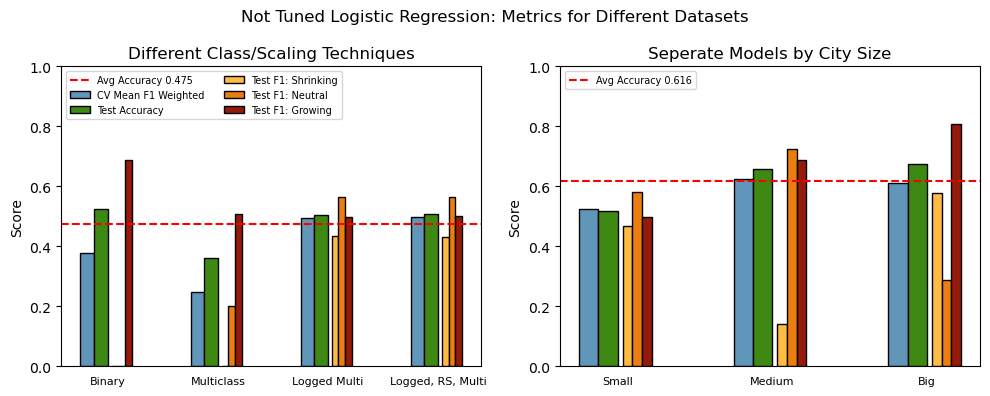

In [70]:
#Untuned
make_plots( model_key='LR', tuned=False, model_name='Logistic Regression')

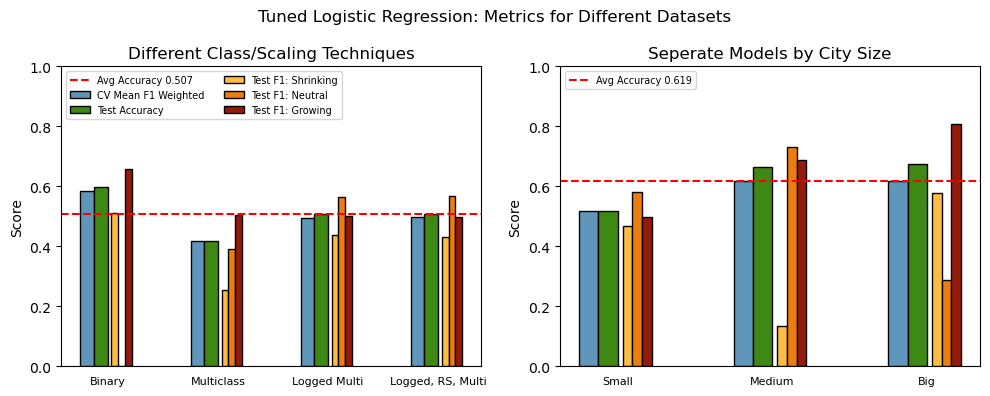

In [28]:
#Tuned
make_plots( model_key='LR', tuned=True, model_name='Logistic Regression')

## What values are driving our regression results?

Look at the coefficient magnitudes (multiplied by std deviation to get rid of scaling) of our logistic regression model for different datasets. See which coefficients are biggest for shrinking and growing classes

In [29]:
data_subsets = ['3classes_log_RS', '3models_small', '3models_med', '3models_big']
growth_key = {-1:"shrinking", 1:"Growing"}

for data_name in data_subsets:
    dd = datasets[data_name]
    LR_GS.fit(dd['X_train'], dd['y_train'].squeeze())
    for key, value in growth_key.items():
        print("\n\nTop 5 variables for dataset {}, Class: {}\n".format(data_name, value), '-'*80, sep="")
        coeff_import = pd.DataFrame( np.std(dd['X_train'], 0)*LR_GS.coef_[key], columns=['coeff'] )
        coeff_import["coeff_abs"] = coeff_import['coeff'].abs()  
        top_5 = coeff_import.sort_values(by='coeff_abs', ascending=False).head(5)
        print(top_5)

datasets.keys()



Top 5 variables for dataset 3classes_log_RS, Class: shrinking
--------------------------------------------------------------------------------
                                                       coeff  coeff_abs
log Housing Units Built in 2014 or Later            0.178765   0.178765
log Households with No Internet Acces              -0.090945   0.090945
log Workers 16 or more who Took Public Transpor... -0.085974   0.085974
log Population Age 65 or more                      -0.081115   0.081115
Workers Age 16 or more                              0.075617   0.075617


Top 5 variables for dataset 3classes_log_RS, Class: Growing
--------------------------------------------------------------------------------
                                             coeff  coeff_abs
log Population 2020                       0.463676   0.463676
log land_area                            -0.110139   0.110139
log Median Home Value                    -0.084397   0.084397
log deaths_per_100K             

dict_keys(['baseline', '3classes', '3classes_log', '3classes_log_RS', '3models_small', '3models_med', '3models_big'])

# Model 2: Random Forest

Same exact methodology, just a different model

In [30]:
#Initialize LR model with baseline parameters
RF_baseline = RandomForestClassifier(random_state=seed)

#Run function to fit baseline model
fit_baseline_model( BASELINE_MODEL=RF_baseline, MODEL_KEY='RF', datasets=datasets)




Baseline Dataset, Binary Target (grow/shrink)
CV F1 Weighted Score for model: RF 
--------------------------------------------------
Mean F1 CV: 0.644 , Std F1 CV: 0.007

Classification Report:
               precision    recall  f1-score   support

          -1       0.63      0.61      0.62      2607
           1       0.66      0.68      0.67      2893

    accuracy                           0.65      5500
   macro avg       0.64      0.64      0.64      5500
weighted avg       0.64      0.65      0.64      5500




MultiClass Target (grow/neutral/shrink)
CV F1 Weighted Score for model: RF 
--------------------------------------------------
Mean F1 CV: 0.585 , Std F1 CV: 0.009

Classification Report:
               precision    recall  f1-score   support

          -1       0.50      0.45      0.47      1554
           0       0.69      0.63      0.66      1975
           1       0.55      0.64      0.59      1971

    accuracy                           0.58      5500
   macro av

## Tune Parameters of RF

In [31]:
#Define new LogReg
RF_GS = RandomForestClassifier(random_state=seed)

# define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7],
    'max_features': ['sqrt', 'log2']
}

#Run tuning function
tune_model( GS_MODEL=RF_GS, MODEL_KEY="RF", PARAM_GRID=param_grid, datasets=datasets)




CV Weighted F1 Score  RF  AFTER TUNING for Baseline Dataset, Binary Target (grow/shrink)
 --------------------------------------------------
Mean: 0.644 , Std: 0.006

Classification Report:
               precision    recall  f1-score   support

          -1       0.62      0.59      0.61      2607
           1       0.65      0.68      0.66      2893

    accuracy                           0.64      5500
   macro avg       0.64      0.63      0.64      5500
weighted avg       0.64      0.64      0.64      5500

Optimal parameters: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}



CV Weighted F1 Score  RF  AFTER TUNING for MultiClass Target (grow/neutral/shrink)
 --------------------------------------------------
Mean: 0.575 , Std: 0.004

Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.43      0.46      1554
           0       0.69      0.63      0.66      1975
           1       0.54      0.64      0.59   

# Random Forest: Graph Metrics

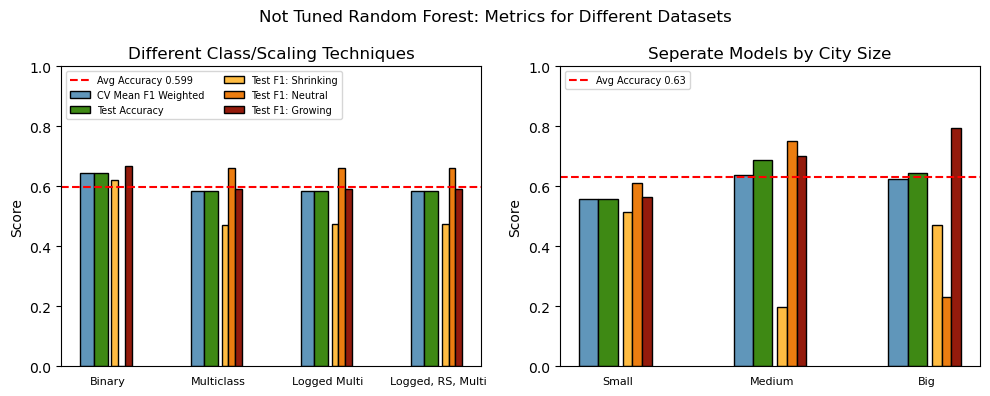

In [32]:
#Untuned
make_plots( model_key='RF', tuned=False, model_name='Random Forest')

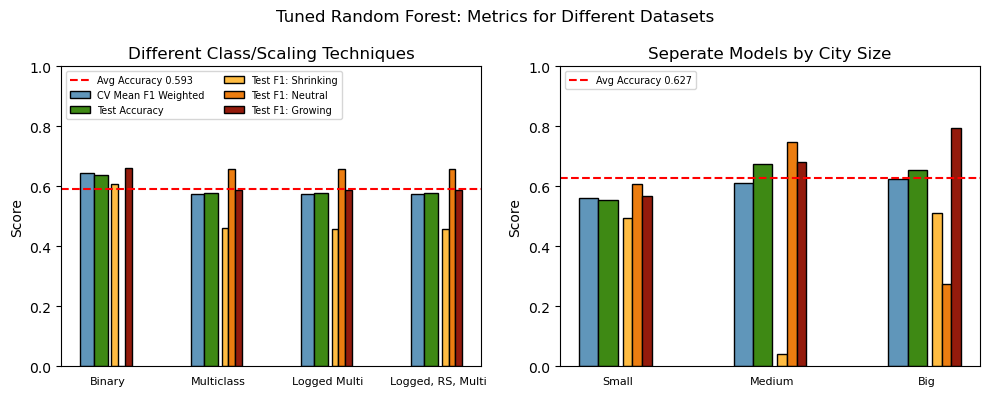

In [33]:
#Tuned
make_plots( model_key='RF', tuned=True, model_name='Random Forest')

# Model 3: Support Vector Machine

In [34]:
#Initialize SVM model with baseline parameters
SVM_baseline = svm.SVC(random_state = seed)

#Run function to fit baseline model
fit_baseline_model( BASELINE_MODEL=SVM_baseline, MODEL_KEY='SVM', datasets=datasets)




Baseline Dataset, Binary Target (grow/shrink)
CV F1 Weighted Score for model: SVM 
--------------------------------------------------
Mean F1 CV: 0.378 , Std F1 CV: 0.0

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2607
           1       0.53      1.00      0.69      2893

    accuracy                           0.53      5500
   macro avg       0.26      0.50      0.34      5500
weighted avg       0.28      0.53      0.36      5500




MultiClass Target (grow/neutral/shrink)
CV F1 Weighted Score for model: SVM 
--------------------------------------------------
Mean F1 CV: 0.307 , Std F1 CV: 0.011

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1554
           0       0.49      0.28      0.35      1975
           1       0.36      0.80      0.50      1971

    accuracy                           0.39      5500
   macro av

### Tune Parameters of SVM

In [35]:
#Define new SVM
SVM_GS = svm.SVC(random_state=seed)

# define parameter grid for grid search
param_grid = {
    'C': [0.1,  10],
   # 'kernel': ['linear', 'poly'],
    'gamma': ['scale', 'auto']
}

#Run tuning function
tune_model( GS_MODEL=SVM_GS, MODEL_KEY="SVM", PARAM_GRID=param_grid, datasets=datasets)




CV Weighted F1 Score  SVM  AFTER TUNING for Baseline Dataset, Binary Target (grow/shrink)
 --------------------------------------------------
Mean: 0.381 , Std: 0.0

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.00      0.01      2607
           1       0.53      1.00      0.69      2893

    accuracy                           0.53      5500
   macro avg       0.76      0.50      0.35      5500
weighted avg       0.75      0.53      0.37      5500

Optimal parameters: {'C': 10, 'gamma': 'auto'}



CV Weighted F1 Score  SVM  AFTER TUNING for MultiClass Target (grow/neutral/shrink)
 --------------------------------------------------
Mean: 0.336 , Std: 0.004

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1554
           0       0.50      0.37      0.43      1975
           1       0.38      0.77      0.51      1971

    accuracy              

# Plot Metrics for SVM 

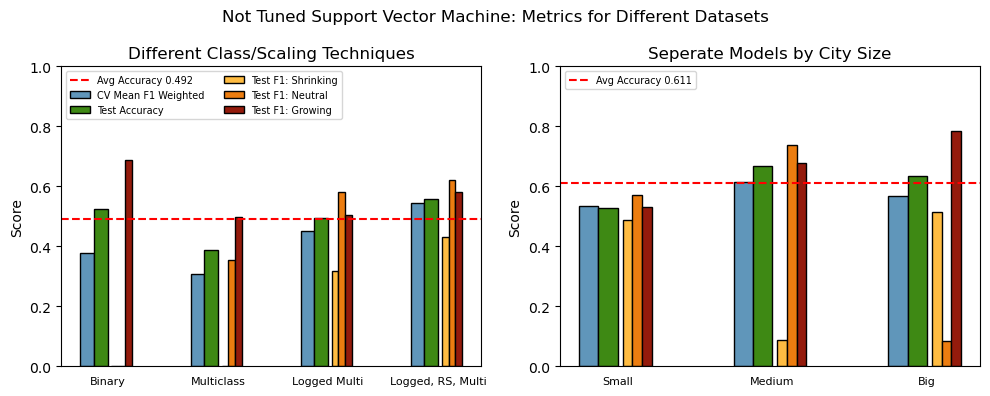

In [36]:
#Untuned
make_plots( model_key='SVM', tuned=False, model_name='Support Vector Machine')

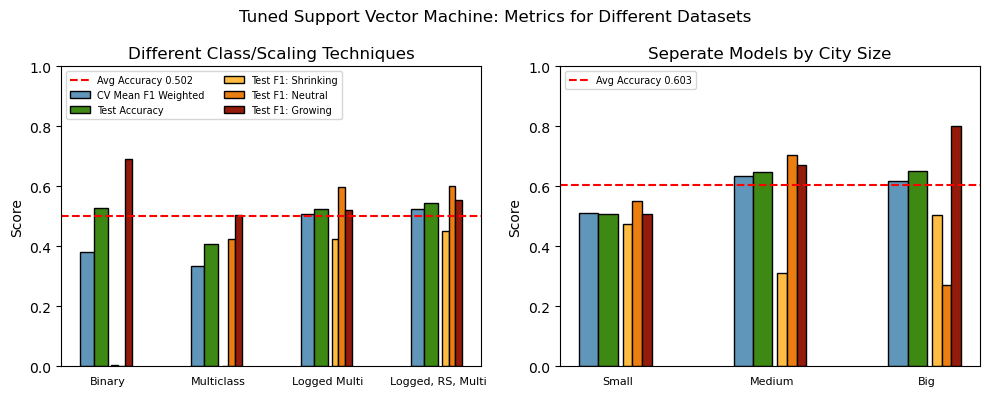

In [37]:
#Tuned
make_plots( model_key='SVM', tuned=True, model_name='Support Vector Machine')

# Model 4: KNN

In [38]:
#Initialize KNN model with baseline parameters
KNN_baseline = KNeighborsClassifier()

#Run function to fit baseline model
fit_baseline_model( BASELINE_MODEL=KNN_baseline, MODEL_KEY='KNN', datasets=datasets)




Baseline Dataset, Binary Target (grow/shrink)
CV F1 Weighted Score for model: KNN 
--------------------------------------------------
Mean F1 CV: 0.539 , Std F1 CV: 0.013

Classification Report:
               precision    recall  f1-score   support

          -1       0.51      0.45      0.48      2607
           1       0.55      0.60      0.57      2893

    accuracy                           0.53      5500
   macro avg       0.53      0.53      0.53      5500
weighted avg       0.53      0.53      0.53      5500




MultiClass Target (grow/neutral/shrink)
CV F1 Weighted Score for model: KNN 
--------------------------------------------------
Mean F1 CV: 0.391 , Std F1 CV: 0.004

Classification Report:
               precision    recall  f1-score   support

          -1       0.33      0.40      0.36      1554
           0       0.42      0.45      0.43      1975
           1       0.39      0.31      0.35      1971

    accuracy                           0.38      5500
   macro 

# Tune KNN

In [39]:
#Define new KNN
KNN_GS = KNeighborsClassifier()

# define parameter grid for grid search
param_grid = {'n_neighbors': [2, 3, 5, 7, 9, 15, 30],
              'weights': ['uniform', 'distance']}

#Run tuning function
tune_model( GS_MODEL=KNN_GS, MODEL_KEY="KNN", PARAM_GRID=param_grid, datasets=datasets)




CV Weighted F1 Score  KNN  AFTER TUNING for Baseline Dataset, Binary Target (grow/shrink)
 --------------------------------------------------
Mean: 0.541 , Std: 0.002

Classification Report:
               precision    recall  f1-score   support

          -1       0.51      0.44      0.47      2607
           1       0.55      0.62      0.58      2893

    accuracy                           0.54      5500
   macro avg       0.53      0.53      0.53      5500
weighted avg       0.53      0.54      0.53      5500

Optimal parameters: {'n_neighbors': 15, 'weights': 'distance'}



CV Weighted F1 Score  KNN  AFTER TUNING for MultiClass Target (grow/neutral/shrink)
 --------------------------------------------------
Mean: 0.427 , Std: 0.009

Classification Report:
               precision    recall  f1-score   support

          -1       0.39      0.32      0.35      1554
           0       0.49      0.54      0.51      1975
           1       0.41      0.42      0.42      1971

    accu

# Plot KNN Metrics

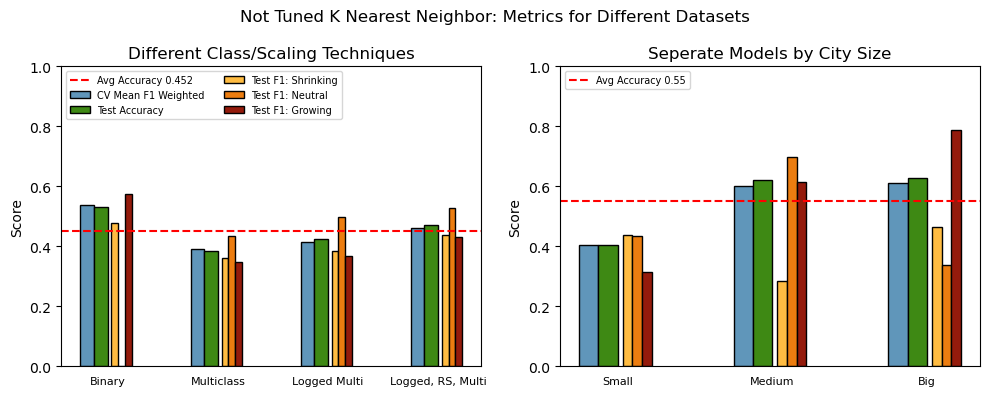

In [40]:
#Untuned
make_plots( model_key='KNN', tuned=False, model_name='K Nearest Neighbor')

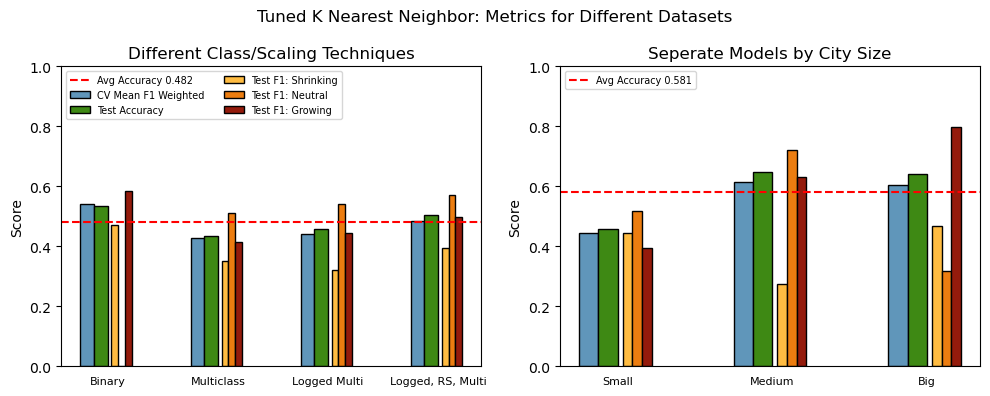

In [41]:
#Tuned
make_plots( model_key='KNN', tuned=True, model_name='K Nearest Neighbor')

# Model 5: Naive Bayes

In [42]:
#Initialize KNN model with baseline parameters
GNB_baseline = GaussianNB()

#Run function to fit baseline model
fit_baseline_model( BASELINE_MODEL=GNB_baseline, MODEL_KEY='GNB', datasets=datasets)




Baseline Dataset, Binary Target (grow/shrink)
CV F1 Weighted Score for model: GNB 
--------------------------------------------------
Mean F1 CV: 0.383 , Std F1 CV: 0.005

Classification Report:
               precision    recall  f1-score   support

          -1       0.25      0.01      0.01      2607
           1       0.52      0.98      0.68      2893

    accuracy                           0.52      5500
   macro avg       0.39      0.49      0.35      5500
weighted avg       0.39      0.52      0.37      5500




MultiClass Target (grow/neutral/shrink)
CV F1 Weighted Score for model: GNB 
--------------------------------------------------
Mean F1 CV: 0.225 , Std F1 CV: 0.005

Classification Report:
               precision    recall  f1-score   support

          -1       0.12      0.00      0.01      1554
           0       0.37      0.03      0.05      1975
           1       0.36      0.96      0.52      1971

    accuracy                           0.35      5500
   macro 

# Tune Naive Bayes

In [43]:
#Define new KNN
GNB_GS = GaussianNB()

# define parameter grid for grid search
param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

#Run tuning function
tune_model( GS_MODEL=GNB_GS, MODEL_KEY="GNB", PARAM_GRID=param_grid, datasets=datasets)




CV Weighted F1 Score  GNB  AFTER TUNING for Baseline Dataset, Binary Target (grow/shrink)
 --------------------------------------------------
Mean: 0.384 , Std: 0.004

Classification Report:
               precision    recall  f1-score   support

          -1       0.26      0.01      0.01      2607
           1       0.52      0.98      0.68      2893

    accuracy                           0.52      5500
   macro avg       0.39      0.49      0.35      5500
weighted avg       0.40      0.52      0.37      5500

Optimal parameters: {'var_smoothing': 1e-10}



CV Weighted F1 Score  GNB  AFTER TUNING for MultiClass Target (grow/neutral/shrink)
 --------------------------------------------------
Mean: 0.225 , Std: 0.003

Classification Report:
               precision    recall  f1-score   support

          -1       0.12      0.00      0.01      1554
           0       0.38      0.03      0.05      1975
           1       0.36      0.96      0.52      1971

    accuracy              

# Plot Metrics

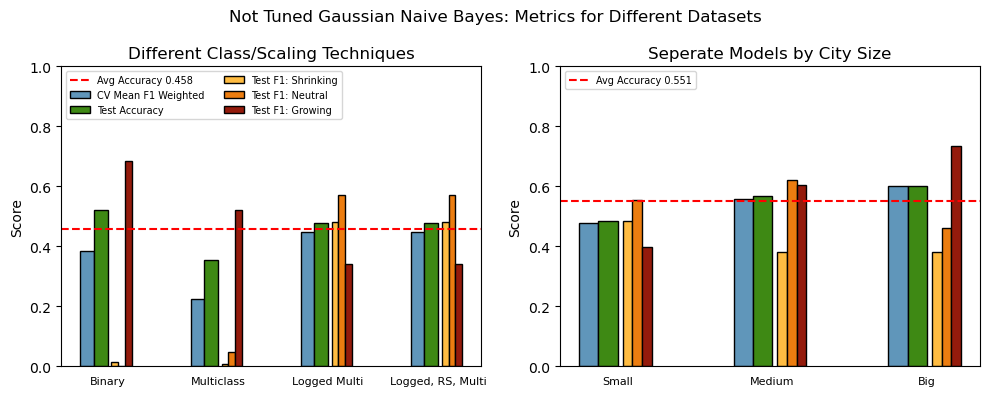

In [44]:
#Untuned
make_plots( model_key='GNB', tuned=False, model_name='Gaussian Naive Bayes')

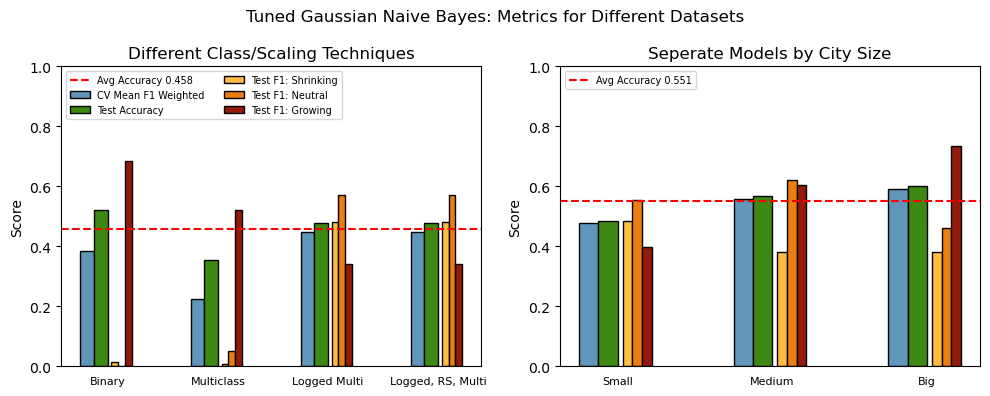

In [45]:
#Tuned
make_plots( model_key='GNB', tuned=True, model_name='Gaussian Naive Bayes')

# Conclusion: Which model is best?

We will look at the performance for 
1. Binary classification
2. Multiclass classification with feature engineering
3. Multiclass classification with seperate models for city sizes (small, medium, big)

Metrics:
1. Test Accuracy
2. Test F1 Weighted Average


In [53]:
models = ['LR', 'SVM', 'RF', 'GNB', 'KNN']
datas = ['baseline', '3classes_log_RS', '3models_small', '3models_med', '3models_big']

accuracy_df = pd.DataFrame( index = models, columns=datas)
f1_weighted = pd.DataFrame( index = models, columns=datas)

for d in datas:
    for m in models:
        accuracy_df.loc[m, d] = round(datasets[d][m]['Class_report_tuned']['accuracy'], 3)
        f1_weighted.loc[m, d] = round(datasets[d][m]['Class_report_tuned']['weighted avg']['f1-score'], 3)
        
accuracy_df = accuracy_df.apply(pd.to_numeric)
f1_weighted = f1_weighted.apply(pd.to_numeric)

accuracy_df.columns = ['Binary Classification', 'MultiClass, Logged, Scaled', "Small Cities", "Medium Cities", "Big Cities"]
f1_weighted.columns = ['Binary Classification', 'MultiClass, Logged, Scaled', "Small Cities", "Medium Cities", "Big Cities"]

cm = sns.light_palette("green", as_cmap=True)   

print("Accuracy by model/dataset:")
accuracy_df.sort_values(by='MultiClass, Logged, Scaled', ascending=False).style.background_gradient(cmap = cm)

Accuracy by model/dataset:


,Binary Classification,"MultiClass, Logged, Scaled",Small Cities,Medium Cities,Big Cities
RF,0.637000,0.578000,0.554000,0.673000,0.655000
SVM,0.527000,0.544000,0.509000,0.649000,0.651000
LR,0.597000,0.506000,0.516000,0.665000,0.674000
KNN,0.535000,0.503000,0.456000,0.648000,0.640000
GNB,0.520000,0.479000,0.484000,0.569000,0.601000


In [71]:
print("Weighted F1 Test Score by model/dataset:")
f1_weighted.sort_values(by='MultiClass, Logged, Scaled', ascending=False).style.background_gradient(cmap = cm)

Weighted F1 Test Score by model/dataset:


,Binary Classification,"MultiClass, Logged, Scaled",Small Cities,Medium Cities,Big Cities
RF,0.636000,0.576000,0.556000,0.621000,0.616000
SVM,0.365000,0.542000,0.510000,0.636000,0.620000
LR,0.588000,0.504000,0.513000,0.629000,0.640000
KNN,0.531000,0.495000,0.447000,0.626000,0.623000
GNB,0.365000,0.463000,0.472000,0.580000,0.606000


# Conclusion: Random Forest seems to be the best, but it depends

**Support vector machine and logistic regression are also promising at times.**

**Gaussian Naive Bayes does the worst.**

**We are able to classify growth rates relatively accurately.**

Some additional conclusions: 

1. Estimating seperate models reveals that **small cities are harder to classify** than medium and big cities. Overall, it seems like small cities are more diverse than big cities and might have more dramatic relationships that cause them to grow or shrink, which we would not have predicted earlier. 

2. Looking at the graphs, we can see that **Tuning our models and feature engineering help**, but how much they help widely varies by model.

3. There **is not a huge difference in the accuracy of models**, and many are able to get close to 55% accuracy after tuning and feature engineering

4. Changing our class to predict (y) to be **multiclass instead of binary seemed beneficial.** Although the accuracy dropped slightly, this needs to be taken alongside the fact that there are 3 classes instead of 4 so it is harder to be correct by guessing. This makes sense because many growth rates are probably close to 0 and counting them as "shrinking" and "growing" equal to greater growth rates was probably confusing the algorithms

# Future Work:


In future work, there are a number of modeling choices that we can explored to further improve the accuracy and robustness of our models. 

One such choice is to look at population growth over a longer time horizon, such as several decades or even a century. This would allow us to gain a more comprehensive understanding of the factors that drive population growth in different cities, as well as the trends and patterns that emerge over time. 

Additionally, incorporating interaction terms between variables could help capture non-linearity in the data and improve the predictive power of the models. This likely is particularly important when modeling complex social phenomena such as population growth, which may be influenced by a variety of interacting factors.

Another important area of future work is to better understand the feature importance for classification. We attempted to briefly do this using logistic regression coefficients but ran out of time to fully delve into this analysis. By identifying which features are most strongly associated with different outcomes, we could gain a deeper understanding of the underlying mechanisms that drive these outcomes, and develop more effective strategies for predicting and managing them. 

Overall, the future work of this machine learning research project presents a rich opportunity for further exploration and discovery. By continuing to refine our models and explore new avenues of analysis, we can gain valuable insights into the complex and dynamic factors that shape population growth across cities in the US. This could ultimately inform more effective policies and interventions that support sustainable and equitable growth, and improve the well-being of individuals and communities across the country.


# References:
- https://stackoverflow.com/questions/26886653/create-new-column-based-on-values-from-other-columns-apply-a-function-of-multi
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
- https://stackoverflow.com/questions/75220289/difference-between-gridsearch-best-estimator-and-best-params
- https://www.statology.org/seaborn-log-scale/
- https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
- https://stackoverflow.com/questions/25212986/how-to-set-some-xlim-and-ylim-in-seaborn-lmplot-facetgrid
- https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
- https://sparkbyexamples.com/pandas/pandas-drop-infinite-values-from-dataframe/
- https://www.tutorialspoint.com/return-the-maximum-of-an-array-or-maximum-ignoring-any-nans-in-python#:~:text=To%20return%20the%20maximum%20of,an%20ndarray%20scalar%20is%20returned.
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
- https://www.geeksforgeeks.org/python-check-whether-given-key-already-exists-in-a-dictionary/
- https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/
- https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
- https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary
- https://stackoverflow.com/questions/55302500/cross-val-score-is-not-working-with-roc-auc-and-multiclass
- https://stackoverflow.com/questions/61640817/f1-score-for-multiclass-labeling-cross-validation
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
- https://en.wikipedia.org/wiki/Multinomial_logistic_regression
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html
- https://stackoverflow.com/questions/28714469/bug-in-pandas-query-method
- https://stackoverflow.com/questions/64943656/plot-3-graphs-2-on-top-and-one-on-bottom-axis-in-python
- https://stackoverflow.com/questions/60628986/remove-xticks-and-yticks-of-gridspec-matlibplot-plot
- https://www.freecodecamp.org/news/how-to-change-legend-fontsize-in-matplotlib/#:~:text=You%20can%20change%20the%20font,value%20for%20the%20fontsize%20parameter.&text=We%20assigned%20a%20font%20size,%3A%20fontsize%3D%2220%22%20
- https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html



